<a href="https://colab.research.google.com/github/amazzoli/RL_introduction/blob/main/notebooks/Cartpole_with_Deep_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cart-pole with Deep Q-learning

Adapted from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

The cart-pole environment is provided by the Open-AI project gymnasium: https://gymnasium.farama.org/environments/classic_control/cart_pole/

In [1]:
# Installing the training environments in which we'll find the cartpole
!pip install gymnasium[classic-control]

# Dependencies for rendering the environments
!pip install pyvirtualdisplay
!sudo apt-get install -y xvfb ffmpeg
!sudo apt-get install xvfb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 a

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Environment library
import gymnasium

# Rendering libraries
from gymnasium.wrappers import RecordVideo
import glob, io, base64
from IPython.display import HTML
from IPython import display as ipythondisplay

## Getting familiar with the cart-pole environment.

## The physical system

<div>
<img src="https://raw.githubusercontent.com/amazzoli/RL_introduction/main/notebooks/cartpole.png" width="500"/>
</div>


The goal of this environment is to balance the pole and keep it in the unstable vertical position.
The algorithm observes four continuous variables, which constitute a **state space** $\Omega = \mathbb{R}^4$.
They are
- Cart Position, $x$
- Cart Velocity, $\dot{x}$
- Pole Angle, $θ$
- Pole Angular Velocity, $\dot{\theta}$

The agent aims to balance the pole by applying a fixed small force in the left and right directions on the cart.
This implies a discrete **action space** composed of two actions:
- 0: push left
- 1: push right

The **transition probabilites**, which in this case are deterministic transitions, are contined in the `CartPole-v1` environment of the `gymnasium` library.
They are based on the underlying physical model, but we ignore them going **model-free**, and trying just to learn from experience.

A **reward** of +1 is granted to the agent at each step while the pole is kept upright.
For practical reasons one can choose to set a fixed number of steps for the game to last (by defaut is 200 steps).
The **return** (the cumulative reward discounted by the factor $\gamma$) of the episdo cannot exceed this number.
We will also choose a $\gamma$ close to one.

The episode ends under the following conditions:
- *Termination*: Pole Angle is greater than ±12°
- *Termination*: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
- *Truncation*: Episode length exceeds a given number of steps as said above

Notice that to maximize the return the agent is interested in maintaining the pole balanced as long as possible.

In [3]:
def run_cartpole(env, policy):
  """
  Run one episode of the cart-pole with a given policy and return the
  environment and the cumulated reward
  """
  state, _ = env.reset()
  terminated, truncated = False, False
  ret = 0
  while not (terminated or truncated):
    action = policy(state)
    state, reward, terminated, truncated, _ = env.step(action)
    ret += reward
  return env, ret


def save_and_display_video(name_prefix, policy, display_it=True):
  """
  A video of an episode of the cart-pole environment is saved in the local Colab
  directory.
  The passed policy is a function taking a state as argument (4d array of floats)
  and returns an action (0 or 1).
  """

  env = gymnasium.make('CartPole-v1', render_mode="rgb_array")

  # Setup the wrapper to record the video
  env.metadata['render_fps'] = 30
  env = RecordVideo(env, video_folder='./videos', name_prefix=name_prefix)

  env, ret = run_cartpole(env, policy)
  print('Episode lasted for', ret, 'steps')
  env.close()


  if display_it:
    video = io.open(glob.glob('videos/'+name_prefix+'-episode-0.mp4')[0], 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''
      <video width="640" height="480" controls>
      <source src="data:video/mp4;base64,{0}" type="video/mp4" />
      </video>
      '''.format(encoded.decode('ascii'))))

There are two main functions that are used in the learning procedure:
- `reset()`: initialize the cart pole in the initial configuration. It returns the initial state (4-dim array of floats) and an auxiliary information variable that we ignore.
- `step(action)`: it makes one step in the physical simulation as a consequence of the passed action (an integer 0 or 1). It returns 5 variables: the new state, the reward, if the environment is terminated, if it is truncated and the auxiliary information.

In [4]:
# Creating the environment
env = gymnasium.make('CartPole-v1', render_mode="rgb_array")

# Initializing
state, _ = env.reset()
print('initial state:', state)

# Applying a force to the left, action=0
state, reward, terminated, truncated, _ = env.step(0)
print('new state:', state)
print('reward:', reward)
print('terminated, truncated:', terminated, truncated)

env.close()

initial state: [0.04891508 0.0327195  0.00066144 0.01031466]
new state: [ 0.04956947 -0.16241193  0.00086773  0.3032062 ]
reward: 1.0
terminated, truncated: False False


## Trying artificial policies

We can play a bit with artificial policies.
For example we can choose a completely random policy and check the typical number of steps the cart survives.

In [5]:
def rand_policy(state):
  return np.random.choice([0,1])

env = gymnasium.make('CartPole-v1', render_mode="rgb_array")
env, ret = run_cartpole(env, rand_policy)
print('With a random policy the pole was balanced for', ret, 'episodes')


def always_left(state):
  return 0

env = gymnasium.make('CartPole-v1', render_mode="rgb_array")
env, ret = run_cartpole(env, always_left)
print('By pushing always left the pole was balanced for', ret, 'episodes')

With a random policy the pole was balanced for 9.0 episodes
By pushing always left the pole was balanced for 8.0 episodes


We can also visualize the episode in a video by using the provided function.

In [6]:
save_and_display_video('rand', rand_policy, display_it=True)

Moviepy - Building video /content/videos/rand-episode-0.mp4.
Moviepy - Writing video /content/videos/rand-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rand-episode-0.mp4
Episode lasted for 18.0 steps


You can try some artificial policies based on your physical intuition.
It shouldn't be hard to be better than a random strategy, but probably is not so easy to reach the end of the episode...

In [7]:
def my_policy(state):
  """
  If the pole is bending towards the left-right I push left-right
  """
  if state[2] < 0:
    return 0
  else:
    return 1

save_and_display_video('my_policy', my_policy, display_it=True)

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/videos/my_policy-episode-0.mp4.
Moviepy - Writing video /content/videos/my_policy-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/my_policy-episode-0.mp4
Episode lasted for 38.0 steps


In [8]:
# Import pytorch
import torch
import torch.nn as nn
import torch.optim as optim

from collections import namedtuple, deque

## Deep Q-Learning

### Idea and definition of the Neural Network

We want to find an "optimal" policy with **Deep Q-Learning**.
The idea of this model-free approach is to use a Neural Network as a function-approximator for the Quality function, the so-called **Deep-Q Network (DQN)** .

The neural network has a number of input nodes equal to the number of state-dimensions, in our case 4 input nodes.
The number of output nodes correspond to the number of actions (2 in our case).
The idea is that, given an input $s = (x, \dot{x}, \theta, \dot{\theta})$, the output of node 0 correspond to our estimate of $Q(s, \text{push left}=0)$, and similarly for the node 1 and $Q(s, \text{push right}=1)$.

As for the tabular Q-Learning the object that we want to minimize is the Bellman equation evaluated in one sample.
If we call $e = (s_t, a_t, R_t, S_{t+1})$ the *experience* of a transition, we can define the "error" in satisfying the optimality equation as:

$$
\delta_e = R_t + \gamma \max_{b \in \mathcal{A}} Q(S_{t+1}, b) - Q(s_t, a_t)
$$

In general, given a set of experiences $\{ e_i \}$ we can define the loss function as Mean Square Error of the errors:

$$
\mathcal{L} = \sum_i \delta_{e_i}^2 .
$$

The minimization of this function trains the NN to be a good approximator of a quality function that satisfy the Bellman equation.

Let us start to define our network, and then we will discuss on how to concretely implement this training.
The choosen architecture is a very simple fully connected network with three hidden layers havin 16 nodes and a ReLU activation function.


In [9]:
class FullyConnectedModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(FullyConnectedModel, self).__init__()

        # Define layers with ReLU activation
        self.linear1 = nn.Linear(input_size, 16)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(16, 16)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(16, 16)
        self.activation3 = nn.ReLU()

        # Output layer without activation function
        self.output_layer = nn.Linear(16, output_size)

        # Initialization using Xavier uniform (a popular technique for initializing weights in NNs)
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, inputs):
        # Forward pass through the layers
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_layer(x)
        return x


class QNetwork:
    def __init__(self, lr, logdir=None):
        # Define Q-network with specified architecture
        self.net = FullyConnectedModel(4, 2)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr(0))

    def update_lr(self, lr):
        for g in self.optimizer.param_groups:
            g['lr'] = lr

### Replay Memory

Next, we introduce one of the key components: Experience Replay.

While deep learning models or other complex ML models for estimating a value function may seem appealing, they did not enjoy success in RL for a long time until Experience Replay was introduced. This is due to a correlation within the training dataset, since consecutive samples collected during the agent's interactions with the environment in RL are highly correlated.
This breaks the i.i.d .assumption for the training data, causing issues in fitting the model.

Experience Replay mitigates this temporal correlation by randomly sampling experiences from a replay memory, that we call $B = \{ e_i \}$.
This set is first initialized by choosing random actions and accumulating experiences until a given `burn_in` number of expreiences is reached.
Later, when the training starts, on each iteration, we store the new observation. Note that we impose a maximum number of experiences, `memory_size`, therefore, after this number is reached, old experiences start to be discarded.

At each iteration, a number of experiences `batch_size` is sampled from the memory, creating a set $B'$ and used to update the network by minimizing:

$$
\mathcal{L} = \sum_{e \in B'} \delta_{e}^2 .
$$


Let's set up the replay memory.


In [10]:
import random
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, memory_size=50000, burn_in=10000):
        # Initializes the replay memory, which stores transitions recorded from the agent taking actions in the environment.
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.memory = deque([], maxlen=memory_size)

    def burn_in_init(self, env):
        # Initialize replay memory with a burn-in number of episodes/transitions.
        terminated, truncated = False, False
        state, _ = env.reset(seed=random.randint(0,100000))
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        for _ in range(self.burn_in):
            # Reset environment if terminated or truncated
            if terminated or truncated:
                state, _ = env.reset(seed=random.randint(0,100000))
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

            # Randomly select an action (left or right) and take a step
            action = torch.tensor(random.sample([0, 1], 1)[0]).reshape(1, 1)
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward])
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            # Store new experience into memory
            transition = Transition(state, action, next_state, reward)
            self.append(transition)
            state = next_state

    def sample_batch(self, batch_size):
        # Returns a batch of randomly sampled transitions to be used for training the model.
        return random.sample(self.memory, batch_size)

    def append(self, transition):
        # Appends a transition to the replay memory.
        self.memory.append(transition)

### Learning Cycle

The pseudo-algorithm for our training is the following.
Notice that the we keep some "explorative noise" by choosing actions according to an *epsilon-greedy* policy.


1. Initialize Q-network.
2. Initialize Replay Memory with `burn-in` experiences taken a random action policy.
3. Initialize/reset the environment.
4. For each episode from 1 to `n_episodes`:
    1. Choose an action based on the current Q-value estimate with probability 1 - `epsilon`.
    2. Take a step and observe the next state and reward.
    3. Store the new experience into the replay memory and possibly discard an old one.
    4. Sample a minibatch with size `batch_size` from the memory.
    5. Train the network with the batched dataset.
5. Every `eval_step` episodes, perform 20 test episodes to evaluate the performance of the current agent.

In [11]:
class DQN_Agent:

    def __init__(self, environment_name, lr, batch_size=32, gamma=0.99, rand_seed=0):
        # Create environment
        self.env = gymnasium.make(environment_name)
        self.rand_seed = rand_seed
        # Create the quality network
        self.policy_net = QNetwork(lr)
        # Create and initialize the memory
        self.rm = ReplayMemory()
        self.rm.burn_in_init(self.env)
        # Store the parameters
        self.lr = lr # The leraning rate is a function of the episode number
        self.batch_size = batch_size
        self.gamma = gamma


    def train(self, episode):

        # Scheduling the learning rate
        self.policy_net.update_lr(self.lr(episode))

        state, _ = self.env.reset(seed=random.randint(0,100000)) # seeding
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        terminated, truncated = False, False

        while not (terminated or truncated):
            with torch.no_grad():
                q_values = self.policy_net.net(state)

            # Decide the next action with epsilon greedy strateg
            action = self.epsilon_greedy_policy(q_values).reshape(1, 1)

            # Take action and observe reward and next state
            next_state, reward, terminated, truncated, _ = self.env.step(action.item())
            reward = torch.tensor([reward])
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            # Store the new experience
            transition = Transition(state, action, next_state, reward)
            self.rm.memory.append(transition)

            # Move to the next state
            state = next_state

            # Sample minibatch with size N from memory
            transitions = self.rm.sample_batch(self.batch_size)
            batch = Transition(*zip(*transitions))
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            # Get current and next state values
            state_action_values = self.policy_net.net(state_batch).gather(1, action_batch) # extract values corresponding to the actions Q(S_t, A_t)
            next_state_values = torch.zeros(self.batch_size)

            with torch.no_grad():
                next_state_values[non_final_mask] = self.policy_net.net(non_final_next_states).max(1)[0] # extract max value

            # Update the model
            expected_state_action_values = (next_state_values * self.gamma) + reward_batch
            criterion = torch.nn.MSELoss()
            loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
            self.policy_net.optimizer.zero_grad()
            loss.backward()
            self.policy_net.optimizer.step()


    def test(self, model_file=None):
        # Evaluates the performance of the agent
        max_t = 200
        state, _ = self.env.reset(seed=random.randint(0,100000))
        rewards = []

        for t in range(max_t):
            state = torch.from_numpy(state).float().unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy_net.net(state)
            # Greedy policy for the evaluation
            action = self.greedy_policy(q_values)
            state, reward, terminated, truncated, _ = self.env.step(action.item())
            rewards.append(reward)
            if terminated or truncated:
                break

        return np.sum(rewards)


    def epsilon_greedy_policy(self, q_values, epsilon=0.05):
        # Implement an epsilon-greedy policy.
        p = random.random()
        if p > epsilon:
            with torch.no_grad():
                return self.greedy_policy(q_values)
        else:
            return torch.tensor([random.randint(0,1)], dtype=torch.long)


    def greedy_policy(self, q_values):
        # Implement a greedy policy for test time.
        return torch.argmax(q_values)


    def get_greedy_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            q_values = self.policy_net.net(state)
        return int(self.greedy_policy(q_values))

### Train and Test DQN Agent

Let's train a DQN agent to evaluate its performance on the CartPole-v0 environment. In this environment, the maximum achievable reward for an agent in each episode is 200. We will train the model over `num_episodes_train` episodes, evaluating its performance every `eval_step` episodes with an additional `num_episodes_eval` test episodes.

This training process will be repeated in parallel `num_trials` times, allowing us to assess the average performance of the agent across episodes.

Please note that this section may take several minutes to complete.


In [25]:
# seeding for reproducibility
torch.manual_seed(10)
random.seed(10)

# Set environment and training parameters
num_episodes_train = 250
eval_step = 25
num_episodes_eval = 30

# Training in parallel for a given number of trials
num_trials = 5
res = np.zeros((num_trials, num_episodes_train // eval_step + 1))

# Scheduling the learing rate to reduce fluctuations in the final part of the training
def learning_rate(episode):
    if episode < 175:
      return 5e-4
    else:
      return 2e-4


# Loop over multiple trials
for i in range(num_trials):
    print('Trial ', i+1)

    reward_means = []

    # Create an instance of the DQN_Agent class
    agent = DQN_Agent('CartPole-v1', lr=learning_rate)

    # Training loop
    for m in range(num_episodes_train):
        agent.train(m)

        # Evaluate the agent
        if m % eval_step == 0 or m == num_episodes_train-1:
            G = np.zeros(num_episodes_eval)
            for k in range(num_episodes_eval):
                G[k] = agent.test()

            reward_mean = G.mean()
            print(f"The test reward for episode {m+1} is {reward_mean} with a standard deviation of {G.std()}.")
            reward_means.append(reward_mean)

    res[i] = np.array(reward_means)

Trial  1
The test reward for episode 1 is 9.166666666666666 with a standard deviation of 0.6368324391514265.
The test reward for episode 26 is 9.5 with a standard deviation of 0.7637626158259734.
The test reward for episode 51 is 9.633333333333333 with a standard deviation of 0.752034278178565.
The test reward for episode 76 is 9.2 with a standard deviation of 0.8326663997864531.
The test reward for episode 101 is 67.66666666666667 with a standard deviation of 24.16379293258591.
The test reward for episode 126 is 164.56666666666666 with a standard deviation of 38.49388118764968.
The test reward for episode 151 is 150.86666666666667 with a standard deviation of 32.543031341423756.
The test reward for episode 176 is 134.3 with a standard deviation of 43.289837144530814.
The test reward for episode 201 is 131.0 with a standard deviation of 42.067406226990826.
The test reward for episode 226 is 121.56666666666666 with a standard deviation of 28.81398194549923.
The test reward for episode 2

Text(0, 0.5, 'Avg. Return')

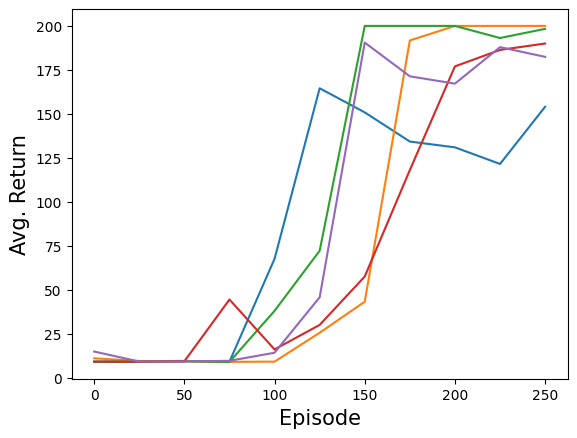

In [26]:
for traj in res:
  plt.plot(np.linspace(0, num_episodes_train, len(traj)), traj)
plt.xlabel('Episode', fontsize=15)
plt.ylabel('Avg. Return', fontsize=15)

In [27]:
torch.manual_seed(0)
random.seed(0)
save_and_display_video('DQN', agent.get_greedy_action, display_it=True)

Moviepy - Building video /content/videos/DQN-episode-0.mp4.
Moviepy - Writing video /content/videos/DQN-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/DQN-episode-0.mp4
Episode lasted for 199.0 steps
